# Homework 08 - IANNwTF - December 13, 2022

### Preparation

Imports, Activate GPU

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# !pip install keras_cv
# import keras_cv

In [22]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

In [23]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

### 2.1 Prepare the Dataset

Load dataset, Data Pipeline

In [24]:
### 2.1 Prepare the Dataset

# mnist_dataset, info = tfds.load("mnist", split=['train', 'test'], as_supervised=True, with_info=True)
# train = mnist_dataset[0]

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, x_val))

In [25]:
def prepare_mnist_data(mnist, batch_size, noise) :
  # create extra dimension for conv2D needs 4D
  mnist = mnist.map(lambda img, img2: (tf.expand_dims(img, -1), tf.expand_dims(img2, -1)))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, img2: (tf.cast(img, tf.float32), tf.cast(img2, tf.float32)))
  #sloppy input normalization, just bringing image values from range [0, 255] to [0, 1]
  mnist = mnist.map(lambda img, img2: ((img/255), (img2/255)))
  #create noise with noise factor between 1 and zero
  # mnist = mnist.map(lambda img, img2: (tf.clip_by_value(((1-noise) * img + noise * tf.random.normal(mean=0.0, stddev=1.0, shape=img.shape)), 0.0, 1.0), img2 ))
  mnist = mnist.map(lambda img, img2: (tf.clip_by_value((img + tf.random.normal(mean=0.0, stddev=1.0, shape=img.shape)), 0.0, 1.0), img2 ))

  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(len(mnist))
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(100)
  #return preprocessed dataset
  return mnist

batch_size = 32
noise_factor = 1
train_data = prepare_mnist_data(train_dataset, batch_size, noise_factor)
val_data = prepare_mnist_data(val_dataset, batch_size, noise_factor)
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None))>

### 2.2 The model

In [34]:
class Encoder(tf.keras.Model) :
  def __init__(self, latent_dim) :
    super(Encoder,self).__init__()
    self.latent_dim = latent_dim
    self.flatten1 = tf.keras.layers.Flatten("channels_last")
    self.dense = tf.keras.layers.Dense(self.latent_dim, activation= "linear")

  def call(self, inputs) :               
    x = self.flatten1(inputs)                   
    out = self.dense(x)  
    return out

In [35]:
class Decoder(tf.keras.Model) :
  def __init__(self) :
    super(Decoder, self).__init__()
    self.dense = tf.keras.layers.Dense(units= 28*28, activation= "relu")
    self.reshape = tf.keras.layers.Reshape((28,28))

  def call(self, inputs) :   
    x = self.dense(inputs)  
    out = self.reshape(x) 
    return out

In [29]:
class Autoencoder(tf.keras.Model) :
  def __init__(self, latent_dim) :
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder(self.latent_dim)
    self.decoder = Decoder()

  def call(self, inputs) : 
    enc = self.encoder(inputs) 
    dec = self.decoder(enc) 
    return dec

In [30]:
model = Autoencoder(2)
def try_model(model, ds) :
  batch = train_dataset.take(32)
  batch = batch.batch(32)
  for x, t in batch :
    enc = model.encoder(x)
    dec = model.decoder(enc)
try_model(model, train_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None))>
Encoder In  (32, 28, 28)
Encoder Flat  (32, 784)
Encoder Embedding  (32, 2)
Decoder In  (32, 2)
Decoder Decode  (32, 784)
Decoder Reshape/Out  (32, 28, 28) 



### 2.3 Training

In [32]:
def train_step(model, input, target, loss_function, optimizer) :
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape :
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function) :
  # test over complete test data
  test_loss_aggregator = []
  for input, target in test_data :
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())
  test_loss = np.mean(test_loss_aggregator)
  return test_loss

In [36]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
latent_dim = 10
# Initialize the model.
model = Autoencoder(latent_dim)
try_model(model, train_data)
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
mse_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)
# Initialize lists for later visualization.
train_losses = []
test_losses = []

#testing once before we begin
test_loss = test(model, val_data, mse_loss)
test_losses.append(test_loss)
#check how model performs on train data once before we begin
train_loss = test(model, train_data, mse_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs
for epoch in range(num_epochs) :
  print(f'Epoch: {str(epoch)} starting with loss {test_losses[-1]}')
  #training (and checking in with training)
  epoch_loss_agg = []
  for input,target in train_data :
    train_loss = train_step(model, input, target, mse_loss, optimizer)
    epoch_loss_agg.append(train_loss)
  #track training loss
  train_losses.append(tf.reduce_mean(epoch_loss_agg))
  #testing, so we can track accuracy and test loss
  test_loss = test(model, val_data, mse_loss)
  test_losses.append(test_loss)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None))>
Epoch: 0 starting with loss 0.10859955847263336
Epoch: 1 starting with loss 0.04462149366736412
Epoch: 2 starting with loss 0.04421005770564079
Epoch: 3 starting with loss 0.044179320335388184
Epoch: 4 starting with loss 0.04387562349438667
Epoch: 5 starting with loss 0.04372609034180641
Epoch: 6 starting with loss 0.04386564716696739
Epoch: 7 starting with loss 0.043761152774095535
Epoch: 8 starting with loss 0.043717093765735626
Epoch: 9 starting with loss 0.043741218745708466


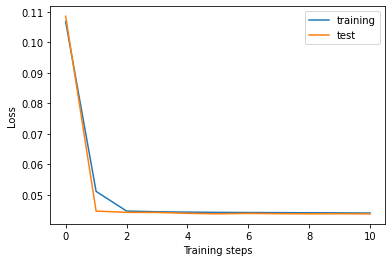

In [37]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

### 2.4 Latent Space Analysis

In [38]:
data = x_val[:1000]
data_labels = y_val[:1000]
data = tf.expand_dims(tf.cast(data, tf.float32)/255, -1)
### Embedding of dimension 10
enc = model.encoder(data)
enc = np.reshape(enc, (enc.shape[0], -1))
### Dimensionality reduction to dim 2
embed = TSNE(n_components=2, perplexity=30).fit_transform(enc)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


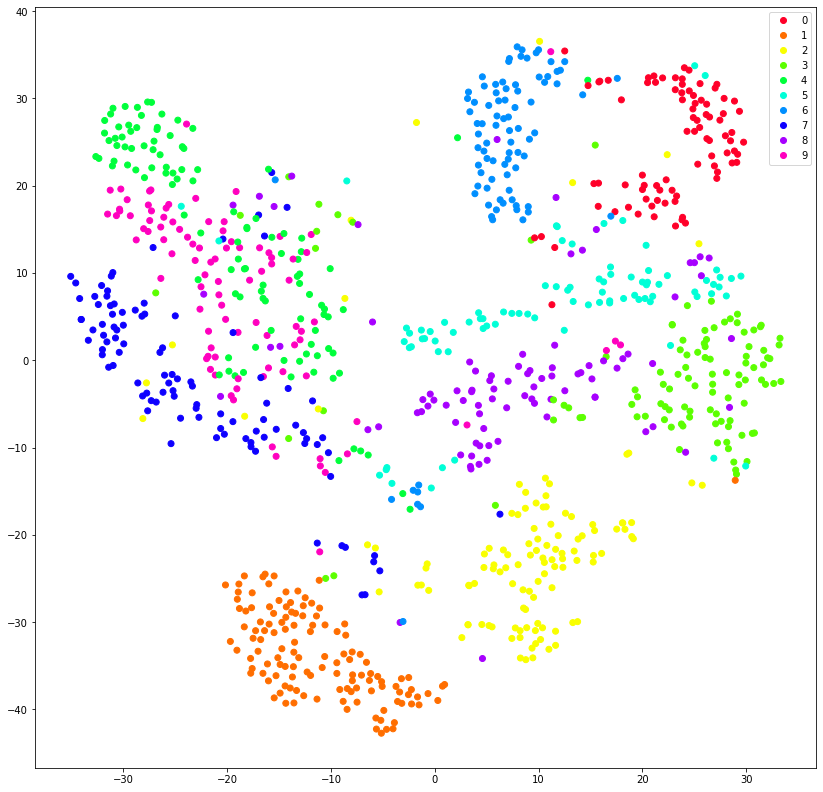

In [39]:
label_names=[str(l) for l in np.arange(10)]
fig = plt.figure(figsize=(14, 14))
scatter = plt.scatter(embed[:,0], embed[:,1], c=data_labels, cmap='gist_rainbow')
plt.legend(handles=scatter.legend_elements()[0], labels=label_names)

Clusters are just as unclear as the images themselves. Though you I expected the greatest intercluster distances between digits, which are morphologically diferent like 0 and 1 (red and orange) and clusters to be close to each other for eg. 4 & 9 (dark green, pink) or 2 and 3 (yellow, light green) 

In [40]:
import plotly.express as px 
fig = px.scatter(x= enc[:,0], y= enc[:,0], color= data_labels)
fig.show()

#### Interpolation 

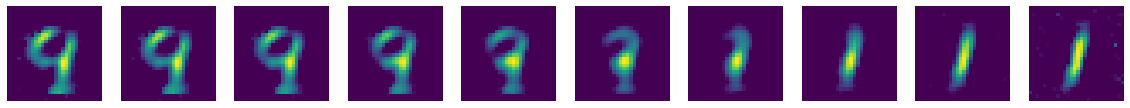

In [56]:
# interpolate linearly between the embeddings of two images and plot the reconstructed images
two_number_images = tf.convert_to_tensor([data[2], data[16]])
encoded = model.encoder(two_number_images)
encoded_1 = encoded[0]
encoded_2 = encoded[1]
number_of_interpol = 10
percent_of_interpol = np.linspace(0, 1, number_of_interpol)
interpolations = []
for percent in percent_of_interpol:
    interpolations.append(encoded_1*percent + encoded_2*(1-percent))
rec_imgs = model.decoder(tf.convert_to_tensor(interpolations))

# plot the reconstructed images
fig = plt.figure(figsize=(2*number_of_interpol,20))
for i in range(number_of_interpol):
    plt.subplot(1, number_of_interpol, i+1)
    plt.imshow(tf.squeeze(rec_imgs[i]))
    plt.axis('off')
plt.show()